In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# general plotting settings

plt.rcParams.update({
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'figure.figsize': (3.5, 3),
    'font.cursive': ['Helvetica-Oblique'],
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Helvetica'],
    'font.size': 9,
    'legend.fontsize':9,
    'lines.linewidth': 1,
    'lines.markersize': 2.5,
    'pdf.fonttype': 42,
    'xtick.labelsize':9, #12
    'xtick.major.size':2,
    'ytick.labelsize':9, # 12
    'ytick.major.size':2,
})

In [3]:
# function definitions

def read_logfile(filepath, delim=' '):
    """Read log file from feedback controller
    
    Parameters:
    -----------
    filepath : str
        path to log file
    
    Returns:
    --------
    logdict : dict
        mapping from variable names in log file to numpy arrays
        containing their data
    """
    def extract_var(loglines, var:str):
        """Extract column data and return as numpy array"""
        col = loglines[0].index(var)
        data = [line[col] for line in loglines[1:]]
        dtype = int if var in ['Timestamp','int_weight'] else float
        if dtype == float:
            data = [d.replace(',','.') for d in data]
        return np.array(data, dtype)
    
    with open(filepath) as f:
        loglines = [line.rstrip(' \n').split(delim) for line in f.readlines()]  
        
    return {k:extract_var(loglines,k) for k in loglines[0]}


def linearfit(x,y,skip=10):
    """Fit y=ax+b, skipping the first 'skip' values
    
    Parameters:
    -----------
    x, y : array-like
        x and y-values of data to fit
    skip : int
        number of entries to skip on x and y

    Returns:
    --------
    (xfit, yfit) : tuple of arrays
        x and y-values of fit
    (a, b) : tuple of int
        linear regression coefficients
    """
    xfit = x[skip:]
    a,b = np.polyfit(xfit,y[skip:],1)
    yfit = a*xfit + b
    return (xfit,yfit), (a,b)


def concat(*args, dim='Timestamp'):
    """Concatenate datasets along dimension dim"""
    keys = np.unique([k for ds in args for k in ds.keys()]) # some datasets have more keys than others
    data = {k:np.concatenate([ds[k] if k in ds else np.ones_like(ds[dim])*np.nan for ds in args]) for k in keys}
    sortids = np.argsort(data[dim])
    data = {k:data[k][sortids] for k in data.keys()}
    dvals, cnts = np.unique(data[dim], return_counts=True)
    delete_ids = [] # remove duplicates (with least number of keys)
    for dval in dvals[cnts>1]:
        left = np.searchsorted(data[dim], dval, side='left')
        right = np.searchsorted(data[dim], dval, side='right')
        pick = left + np.argmax(np.isnan([data[k][i] for k in keys]).sum() for i in range(left,right))
        delete_ids.append([i for i in range(left,right) if i!=pick])
        print(dval, left, right, delete_ids)
    return {k:np.delete(data[k], delete_ids) for k in keys}


def logfileplot_v1(ds, addfp=None, leg=True, figname=None):
    #ds = read_logfile(LOGFILE)
    #logname = os.path.splitext(os.path.basename(LOGFILE))[0]
    #print("reading", LOGFILE)
    print(f"applied feedforward: kff: {kff}, t0: {t0}, max: {ffmax}")
    
    # fit n_aod
    fit, coef = linearfit(ds[x],ds[y1], skip=nskip)
    baseyear = fit[0][0] - fit[1][0]/coef[0]
    r = np.corrcoef(fit[1],ds[y1][nskip:])[1,0]
    print(f"fitting years [{ds[x][nskip]} - {ds[x][-1]}]")
    print(f"fit results: kff_fit = {coef[0]}, t0_fit = {baseyear}")
    print(f"correlation of fit with data: {r}")
    
    # y plot (n_aod)
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(ds[x], ds[y1],'.', c=c, label=r'$n_{AOD}$', zorder=5)
    ax.set_xlabel('year')
    ax.set_ylim(ylim)
    ax.grid(c=c, axis='both', lw=.3, alpha=.5)
    ax.tick_params(axis='y', color=c, labelcolor=c)
    
    # fit plots
    p1=ax.plot(ds[x], np.clip(kff*(ds[x]-t0), a_min=None, a_max=ffmax), ':', c='brown',label=r'$k_{ff}(t-t_{0})$') # feedforward
    ax.plot(*(fit),'--', c='red',label=(r'$n_{AOD,fit}$')) # linear fit

    # additional fit plot
    if addfp:
        fit, coef = linearfit(ds[x][addfp],ds[y1][addfp], skip=0)
        baseyear = fit[0][0] - fit[1][0]/coef[0]
        print(f"fitting years [{ds[x][addfp][0]} - {ds[x][addfp][-1]}]")
        print(f"fit results: kff_fit = {coef[0]}, t0_fit = {baseyear}")
        pa = ax.plot(*(fit), '--', c='red')

    # dT plot
    p2 = ax.plot(ds[x], ds[y2], '.-', c=c2, label=r'$\Delta T_0$ [K]',alpha=1)
    if leg:
        ax.legend(loc=loc)
    
    fig.tight_layout()
    if figname:
        print(f"saving {figname+ext}")
        fig.savefig(figname+ext, dpi=300, transparent=False)


def logfileplot_v2():
    """Different style logfile plot"""
    ds = read_logfile(LOGFILE)
    logname = os.path.splitext(os.path.basename(LOGFILE))[0]
    print("reading", LOGFILE)
    print(f"applied feedforward: {kff=}, {t0=}")
    
    # fit n_aod
    fit, coef = linearfit(ds[x],ds[y1], skip=nskip)
    baseyear = fit[0][0] - fit[1][0]/coef[0]
    r = np.corrcoef(fit[1],ds[y1][nskip:])[1,0]
    print(f"fitting years [{ds[x][nskip]} - {ds[x][-1]}]")
    print(f"fit results: kff_fit = {coef[0]}, t0_fit = {baseyear}")
    print(f"correlation of fit with data: {r}")
    
    # y plot (n_aod)
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(ds[x], ds[y1],'.', c=c, label=r'$n_{AOD}$')
    ax.set_xlabel('year')
    ax.set_ylabel(r'$n_{AOD}$', c=c)
    ax.set_ylim(ylim)
    ax.grid(c=c, axis='both', lw=.3, alpha=.5)
    ax.tick_params(axis='y', color=c, labelcolor=c)
    
    # fit plots
    p1=ax.plot(ds[x], kff*(ds[x]-t0), ':', c=c,label=r'$k_{ff}(t-t_{0})$')
    ax.plot(*(fit),'--', c=c,label=(r'$n_{AOD,fit}$'))
    
    # y2 plot (dT)
    ax2 = ax.twinx()
    p2 = ax2.plot(ds[x], ds[y2], '.-', c=c2, label=r'$\Delta T_0$ [K]',alpha=1)
    ax2.set_ylabel(r'$\Delta T_0$ [K]',c=c2)
    ax2.grid(axis='y', c=c2, lw=.3)
    ax2.tick_params(axis='y', color=c2, labelcolor=c2)
    ax2.set_ylim(ylim2)

    # text and legend
    ax.text(2067,-0.35,r'$k_{ff}$'+f' = {kff:.5f}\n'+r'$t_0$'+f' = {t0}\n'+r'$k_{ff,fit}$'
            +f' = {coef[0]:0.5f} \n'+r'$t_{0,fit}$'+f' = {baseyear:0.2f})')
    ax.legend(loc='upper left')
    
    fig.tight_layout()
    print(f"saving {logname+ext}")
    fig.savefig(logname+ext, dpi=300, transparent=False)
    # plt.show()

### CESM2(CAM6) SAI2020

applied feedforward: kff: 0.010345238095238097, t0: 2020, max: 0.828
fitting years [2020 - 2100]
fit results: kff_fit = 0.008375744760525857, t0_fit = 2020.2105692088228
correlation of fit with data: 0.9983233436965736
saving SAI2020.aodfit.2020-2100.pdf


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


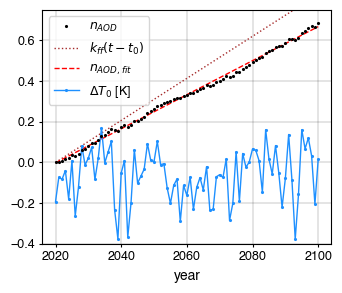

In [4]:
figname = 'SAI2020.aodfit.2020-2100'
ds = read_logfile('./ControlLog_b.e21.BSSP585cmip6.f09_g17.2020feedback.02.2020-2100.txt')
CAM_WACCM_corrfac = 5.5/(5.5-1.3)
kff = 0.0079 * CAM_WACCM_corrfac   # applied feedforward constant kff
t0 = 2020       # applied feedforward base year
ffmax = 0.828
x = 'Timestamp' # x-axis variable
y1 = 'L0'; c = 'k'; ylim = [-0.4,0.75]     # properties of left y-axis variable
y2 = 'dT0'; c2 = 'dodgerblue'; ylim2 = [-0.49, 0.49] # properties of right y-axis variable
nskip = 0      # number of years to skip when fitting y1 data
loc = 'upper left' # legend location
ext = '.pdf'    # figure save format

logfileplot_v1(ds, figname=figname)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


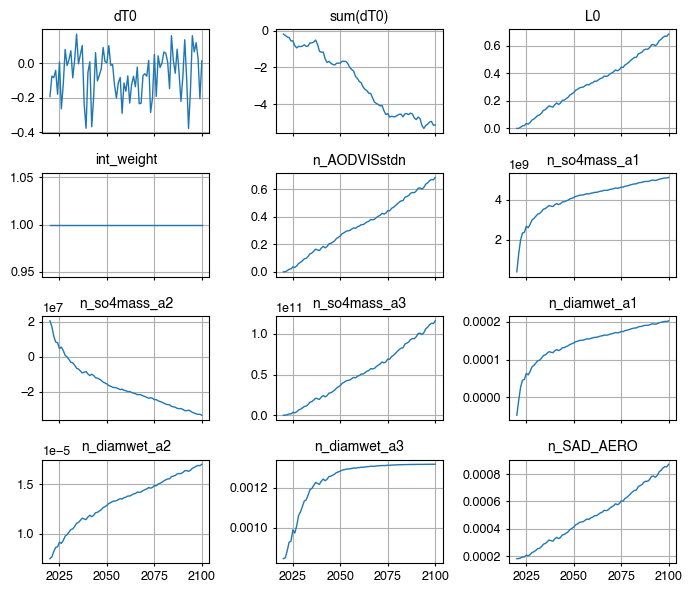

In [5]:
figname = 'SAI2020.allvar.2020-2100'
fig, ax = plt.subplots(4,3, sharex=True, figsize=(7,6))
cols = list(ds.keys())
for i,axi in enumerate(ax.flatten()):
    axi.plot(ds['Timestamp'], ds[cols[i+1]])
    axi.set_title(cols[i+1])
    axi.grid()
fig.tight_layout()
fig.savefig(figname+ext, dpi=300, transparent=False)
plt.show()

### CESM2(CAM6) SAI2020 with 2130 extension

2100 80 82 [[81]]
applied feedforward: kff: 0.010345238095238097, t0: 2020, max: 0.828
fitting years [2100 - 2131]
fit results: kff_fit = 0.0005352929214072755, t0_fit = 861.174739574386
correlation of fit with data: 0.5458061777491605
fitting years [2020 - 2100]
fit results: kff_fit = 0.008375744760525857, t0_fit = 2020.2105692088228
saving SAI2020.aodfit.2020-2130.pdf


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


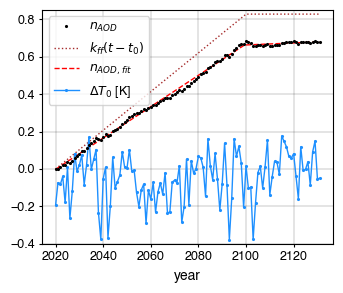

In [6]:
figname = 'SAI2020.aodfit.2020-2130'
ds1 = read_logfile('./ControlLog_b.e21.BSSP585cmip6.f09_g17.2020feedback.02.2020-2100.txt')
ds2 = read_logfile('./ControlLog_b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02.2100-2131.txt')
ds = concat(ds1, ds2)
CAM_WACCM_corrfac = 5.5/(5.5-1.3)
kff = 0.0079 * CAM_WACCM_corrfac   # applied feedforward constant kff
t0 = 2020       # applied feedforward base year
ffmax = 0.828
x = 'Timestamp' # x-axis variable
y1 = 'L0'; c = 'k'; ylim = [-0.4,0.85]     # properties of left y-axis variable
y2 = 'dT0'; c2 = 'dodgerblue'; ylim2 = [-0.49, 0.49] # properties of right y-axis variable
nskip = 80      # number of years to skip when fitting y1 data
loc = 'upper left' # legend location
ext = '.pdf'    # figure save format

logfileplot_v1(ds, addfp=range(0,81), figname=figname)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


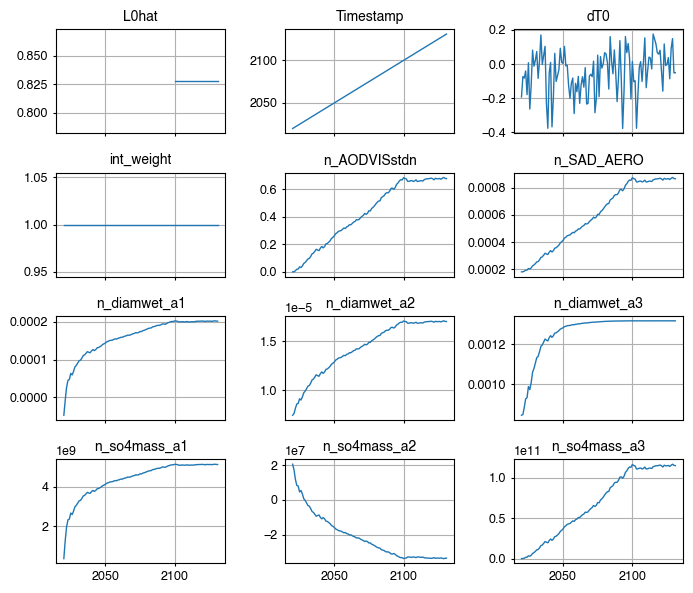

In [7]:
figname = 'SAI2020.allvar.2020-2130'
fig, ax = plt.subplots(4,3, sharex=True, figsize=(7,6))
cols = list(ds.keys())
for i,axi in enumerate(ax.flatten()):
    axi.plot(ds['Timestamp'], ds[cols[i+1]])
    axi.set_title(cols[i+1])
    axi.grid()
fig.tight_layout()
fig.savefig(figname+ext, dpi=300, transparent=False)
plt.show()

### CESM2(CAM6) SAI2080

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


applied feedforward: kff: 0.0096, t0: 2028, max: 0.691
fitting years [2090 - 2100]
fit results: kff_fit = 0.00953849687277099, t0_fit = 2022.7194456218785
correlation of fit with data: 0.9578176207390644
saving SAI2080.aodfit.2080-2100.pdf


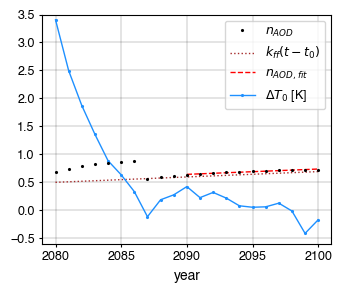

In [8]:
figname = 'SAI2080.aodfit.2080-2100'
ds = read_logfile('./ControlLog_b.e21.BSSP585cmip6.f09_g17.feedback.09.2080-2100.txt')
kff = 0.0096   # applied feedforward constant kff
t0 = 2028       # applied feedforward base year
ffmax = 0.691
x = 'Timestamp' # x-axis variable
y1 = 'L0'; c = 'k'; ylim = [-0.6,3.5]     # properties of left y-axis variable
y2 = 'dT0'; c2 = 'dodgerblue'; ylim2 = [-0.59, 0.49] # properties of right y-axis variable
nskip = 10      # number of years to skip when fitting y1 data
loc = 'upper right' # legend location
ext = '.pdf'    # figure save format

logfileplot_v1(ds, figname=figname)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


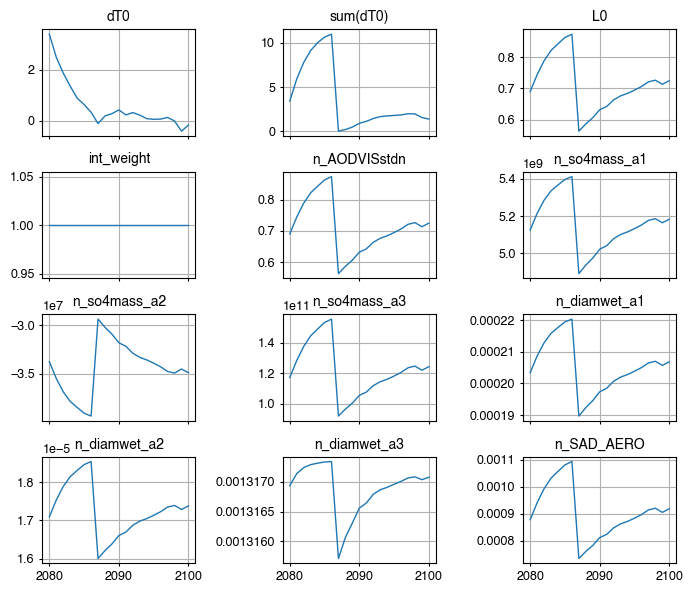

In [9]:
figname = 'SAI2080.allvar.2080-2100'
fig, ax = plt.subplots(4,3, sharex=True, figsize=(7,6))
cols = list(ds.keys())
for i,axi in enumerate(ax.flatten()):
    axi.plot(ds['Timestamp'], ds[cols[i+1]])
    axi.set_title(cols[i+1])
    axi.grid()
fig.tight_layout()
fig.savefig(figname+ext, dpi=300, transparent=False)
plt.show()

### CESM2(CAM6) SAI2080 with 2130 extension

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


2100 20 22 [[21]]
applied feedforward: kff: 0.0096, t0: 2028, max: 0.691
fitting years [2100 - 2131]
fit results: kff_fit = -0.004372863386954936, t0_fit = 2258.3349633106013
correlation of fit with data: 0.9214097989515103
fitting years [2087 - 2100]
fit results: kff_fit = 0.012354476363426499, t0_fit = 2039.5007711663407
saving SAI2080.aodfit.2080-2130.pdf


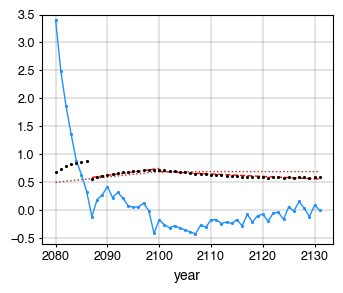

In [10]:
figname = 'SAI2080.aodfit.2080-2130'
ds1 = read_logfile('./ControlLog_b.e21.BSSP585cmip6.f09_g17.feedback.09.2080-2100.txt')
ds2 = read_logfile('./ControlLog_b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01.2100-2131.txt')
ds = concat(ds1, ds2)
kff = 0.0096   # applied feedforward constant kff
t0 = 2028       # applied feedforward base year
ffmax = 0.691
x = 'Timestamp' # x-axis variable
y1 = 'L0'; c = 'k'; ylim = [-0.6,3.5]     # properties of left y-axis variable
y2 = 'dT0'; c2 = 'dodgerblue'; ylim2 = [-0.59, 0.49] # properties of right y-axis variable
nskip = 20      # number of years to skip when fitting y1 data
loc = 'upper right' # legend location
ext = '.pdf'    # figure save format

logfileplot_v1(ds, addfp=range(7,21), leg=False, figname=figname)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


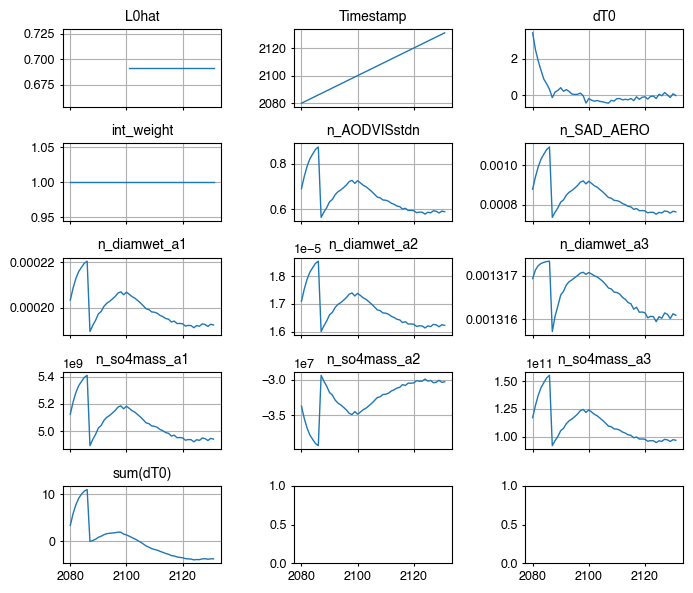

In [11]:
figname = 'SAI2080.allvar.2080-2130'
fig, ax = plt.subplots(5,3, sharex=True, figsize=(7,6))
cols = list(ds.keys())
for i,axi in enumerate(ax.flatten()):
    try:
        axi.plot(ds['Timestamp'], ds[cols[i+1]])
        axi.set_title(cols[i+1])
        axi.grid()
    except IndexError:
        pass
fig.tight_layout()
fig.savefig(figname+ext, dpi=300, transparent=False)
plt.show()

### CESM2(CAM6) SAI2020 and SAI2080 with 2130 extension

In [4]:
def logfileplot_v3(ds, ax=None, addfp=None, leg=True, figname=None):
    #ds = read_logfile(LOGFILE)
    #logname = os.path.splitext(os.path.basename(LOGFILE))[0]
    #print("reading", LOGFILE)
    print(f"applied feedforward: kff: {kff}, t0: {t0}, max: {ffmax}")
    
    # fit n_aod
    fit, coef = linearfit(ds[x],ds[y1], skip=nskip)
    baseyear = fit[0][0] - fit[1][0]/coef[0]
    r = np.corrcoef(fit[1],ds[y1][nskip:])[1,0]
    print(f"fitting years [{ds[x][nskip]} - {ds[x][-1]}]")
    print(f"fit results: kff_fit = {coef[0]}, t0_fit = {baseyear}")
    print(f"correlation of fit with data: {r}")
    
    # y plot (n_aod)
    if ax:
        fig = ax.figure
    else:
        fig = plt.figure()
        ax = fig.gca()
    ax.plot(ds[x], ds[y1],'.', c=c, label=r'$n_{AOD}$', zorder=5)
    ax.set_xlabel('year')
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_yticks(yticksminor, minor=True)
    ax.grid(c=c, axis='both', which='both', lw=.3, alpha=.5)
    ax.tick_params(axis='y', color=c, labelcolor=c)
    
    # fit plots
    p1=ax.plot(ds[x], np.clip(kff*(ds[x]-t0), a_min=None, a_max=ffmax), ':', c='brown',label=r'$k_{ff}(t-t_{0})$') # feedforward
    ax.plot(*(fit),'--', c=c,label=(r'$n_{AOD,fit}$')) # linear fit

    # additional fit plot
    if addfp:
        fit, coef = linearfit(ds[x][addfp],ds[y1][addfp], skip=0)
        baseyear = fit[0][0] - fit[1][0]/coef[0]
        print(f"fitting years [{ds[x][addfp][0]} - {ds[x][addfp][-1]}]")
        print(f"fit results: kff_fit = {coef[0]}, t0_fit = {baseyear}")
        pa = ax.plot(*(fit), '--', c='red')

    # dT plot
    ax2 = ax.twinx()
    p2 = ax2.plot(ds[x], ds[y2], '.-', c=c2, label=r'$\Delta T_0$',alpha=1)
    ax2.set_ylim(ylim2)
    ax2.set_yticks(y2ticks)
    ax2.tick_params(axis='y', color=c2, labelcolor=c2)

    if leg:
        lines,labels = ax.get_legend_handles_labels()
        lines += p2
        labels += [p2[0].get_label()]
        ax.legend(loc=loc, handles=lines, labels=labels)

2100 80 82 [[81]]
applied feedforward: kff: 0.010345238095238097, t0: 2020, max: 0.828
fitting years [2100 - 2131]
fit results: kff_fit = 0.0005352929214072755, t0_fit = 861.174739574386
correlation of fit with data: 0.5458061777491605
fitting years [2020 - 2100]
fit results: kff_fit = 0.008375744760525857, t0_fit = 2020.2105692088228
2100 20 22 [[21]]
applied feedforward: kff: 0.0096, t0: 2028, max: 0.691
fitting years [2100 - 2131]
fit results: kff_fit = -0.004372863386954935, t0_fit = 2258.3349633106013
correlation of fit with data: 0.9214097989515101
fitting years [2087 - 2100]
fit results: kff_fit = 0.012354476363426499, t0_fit = 2039.5007711663407
saving SAI2020-2080.aodfit.2020-2100.pdf


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


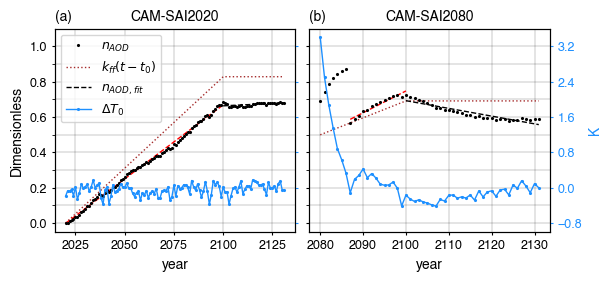

In [5]:
figname = 'SAI2020-2080.aodfit.2020-2100.pdf'
fig,axs = plt.subplots(1,2,figsize=(6,2.7), sharey=True, constrained_layout=True)

# carefully choose ylimits to match horizontal grid lines (used scale of 1:4)
ylim = [-0.05,1.1]; yticks = np.arange(0,1.01,0.2); yticksminor = np.arange(0,1.01,0.1)
ylim2 = [-1,3.6]; y2ticks = np.arange(-0.8,3.21,0.8); y2ticksminor = np.arange(-0.8,3.21,0.4)

ax = axs[0]
ds1 = read_logfile('./ControlLog_b.e21.BSSP585cmip6.f09_g17.2020feedback.02.2020-2100.txt')
ds2 = read_logfile('./ControlLog_b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02.2100-2131.txt')
ds = concat(ds1, ds2)
CAM_WACCM_corrfac = 5.5/(5.5-1.3)
kff = 0.0079 * CAM_WACCM_corrfac   # applied feedforward constant kff
t0 = 2020       # applied feedforward base year
ffmax = 0.828
x = 'Timestamp' # x-axis variable
y1 = 'L0'; c = 'k'; #ylim = [-0.03,1.03]     # properties of left y-axis variable
y2 = 'dT0'; c2 = 'dodgerblue';# ylim2 = [-0.6, 3.5] # properties of right y-axis variable
nskip = 80      # number of years to skip when fitting y1 data
loc = 'upper left' # legend location
logfileplot_v3(ds, ax=ax, addfp=range(0,81))

ax=axs[1]
ds1 = read_logfile('./ControlLog_b.e21.BSSP585cmip6.f09_g17.feedback.09.2080-2100.txt')
ds2 = read_logfile('./ControlLog_b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01.2100-2131.txt')
ds = concat(ds1, ds2)
kff = 0.0096   # applied feedforward constant kff
t0 = 2028       # applied feedforward base year
ffmax = 0.691
x = 'Timestamp' # x-axis variable
y1 = 'L0'; c = 'k'; #ylim = [-0.03,1.03]     # properties of left y-axis variable
y2 = 'dT0'; c2 = 'dodgerblue'; #ylim2 = [-0.6, 3.5] # properties of right y-axis variable
nskip = 20      # number of years to skip when fitting y1 data
loc = 'upper right' # legend location
logfileplot_v3(ds, ax=ax, addfp=range(7,21), leg=False)

axs2 = [axs[i].get_shared_x_axes().get_siblings(axs[i])[0] for i in range(0,2)]
axs2[0].tick_params(labelright=False)
axs[0].set_ylabel('Dimensionless')
axs2[1].set_ylabel('K', c=c2)
axs[0].set_title('CAM-SAI2020')
axs[1].set_title('CAM-SAI2080')
axs[0].set_title('(a)', loc='left')
axs[1].set_title('(b)', loc='left')
print(f"saving {figname}")
fig.savefig(figname, dpi=300, transparent=False)